In [122]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('HPa', 6, 2)

In [4]:
from src.analysis import detect_epoch_ripples, decode_ripple_clusterless
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY, REPLAY_COVARIATES)

ripple_times = detect_epoch_ripples(
        epoch_key, ANIMALS, SAMPLING_FREQUENCY)

replay_info, _, _ = decode_ripple_clusterless(epoch_key, ANIMALS, ripple_times)

INFO:src.analysis:Detecting ripples
INFO:src.analysis:Decoding ripples
INFO:src.ripple_decoding.decoders:Fitting state transition model...
INFO:src.ripple_decoding.decoders:Fitting observation model...
INFO:src.analysis:Predicting replay types


In [5]:
from src.data_processing import make_neuron_dataframe
neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False).query('numspikes > 0')

In [25]:
from src.data_processing import reshape_to_segments, get_spike_indicator_dataframe

neurons = [
    reshape_to_segments(get_spike_indicator_dataframe(neuron_key, ANIMALS),
        ripple_times, window_offset=(-0.100, 0.100), segment_name='ripple_number')
    for neuron_key in neuron_info.index]

neurons_after_ripple = [
    reshape_to_segments(get_spike_indicator_dataframe(neuron_key, ANIMALS),
        ripple_times, window_offset=(0.00, 0.100), segment_name='ripple_number')
    for neuron_key in neuron_info.index]

In [35]:
spikes = pd.concat(neurons, keys=neuron_info.neuron_id.values, axis=1)

### Replay covariates, no_time, no history

In [208]:
from patsy import dmatrices, build_design_matrices
from statsmodels.api import GLM, families

data = pd.merge(neurons_after_ripple[-1].reset_index(),
                replay_info.reset_index(), on='ripple_number')

response, design_matrix = dmatrices('is_spike ~ replay_task + replay_order', data)
fit = GLM(response, design_matrix, family=families.Poisson()).fit()

print(design_matrix.design_info.column_names)
print(fit.params)

['Intercept', 'replay_task[T.Outbound]', 'replay_order[T.Reverse]']
[-6.79385725 -0.55298208  0.31026069]


### Replay Covariates and time interaction, no history

In [201]:
data = pd.merge(neurons[-1].reset_index(),
                replay_info.reset_index(), on='ripple_number')
response, design_matrix = dmatrices('is_spike ~ replay_order * bs(time, df=5)', data)
fit = GLM(response, design_matrix, family=families.Poisson()).fit()
print(design_matrix.design_info.column_names)
print(fit.params)

['Intercept', 'replay_order[T.Reverse]', 'bs(time, df=5)[0]', 'bs(time, df=5)[1]', 'bs(time, df=5)[2]', 'bs(time, df=5)[3]', 'bs(time, df=5)[4]', 'replay_order[T.Reverse]:bs(time, df=5)[0]', 'replay_order[T.Reverse]:bs(time, df=5)[1]', 'replay_order[T.Reverse]:bs(time, df=5)[2]', 'replay_order[T.Reverse]:bs(time, df=5)[3]', 'replay_order[T.Reverse]:bs(time, df=5)[4]']
[-7.17116145  0.41780103  0.41802596 -0.66327245  1.1821262  -2.26820007
  1.67814088  0.54435978 -2.34369001  0.6565346   0.83634164 -0.74286686]


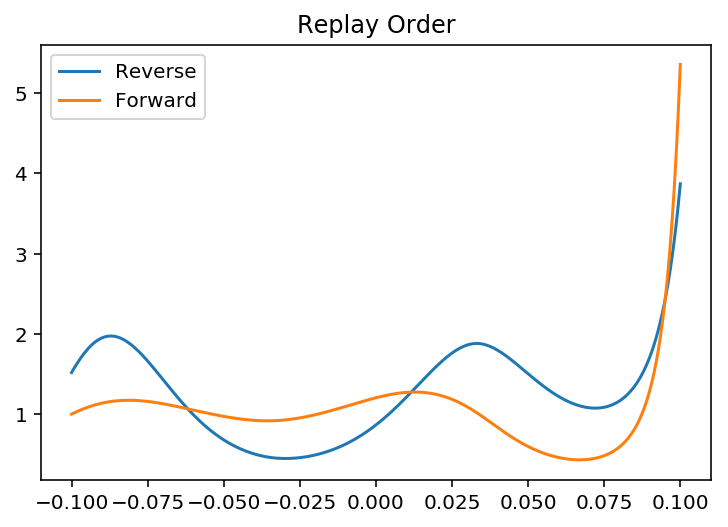

In [207]:
unique_time = data.time.unique()
n_time = len(unique_time)
replay_order_levels = data.replay_order.unique()

for level in replay_order_levels:
    predict_data = {'time': unique_time, 'replay_order': np.repeat(level, (n_time,))}

    predict_design_matrix = build_design_matrices(
        [design_matrix.design_info], predict_data)[0]
    predict_design_matrix[:, 0] = 0
    plt.plot(unique_time, np.exp(np.dot(predict_design_matrix, fit.params)), label=level)
plt.legend()
plt.title('Replay Order');

In [389]:
data = pd.merge(neurons[-1].reset_index(),
                replay_info.reset_index(), on='ripple_number')

response, design_matrix = dmatrices('is_spike ~ replay_task * bs(time, df=5) + replay_order * bs(time, df=5)', data,
                                    return_type='dataframe')
fit = GLM(response, design_matrix, family=families.Poisson()).fit()

print(fit.params)

Intercept                                   -6.794746
replay_task[T.Outbound]                     -0.507972
replay_order[T.Reverse]                      0.310566
bs(time, df=5)[0]                           -0.610718
bs(time, df=5)[1]                           -2.770835
bs(time, df=5)[2]                            1.924792
bs(time, df=5)[3]                           -2.236974
bs(time, df=5)[4]                            1.342339
replay_task[T.Outbound]:bs(time, df=5)[0]    1.345021
replay_task[T.Outbound]:bs(time, df=5)[1]    2.814096
replay_task[T.Outbound]:bs(time, df=5)[2]   -1.019044
replay_task[T.Outbound]:bs(time, df=5)[3]   -0.451621
replay_task[T.Outbound]:bs(time, df=5)[4]    0.504938
replay_order[T.Reverse]:bs(time, df=5)[0]    0.824326
replay_order[T.Reverse]:bs(time, df=5)[1]   -1.773777
replay_order[T.Reverse]:bs(time, df=5)[2]    0.425180
replay_order[T.Reverse]:bs(time, df=5)[3]    0.736735
replay_order[T.Reverse]:bs(time, df=5)[4]   -0.624846
dtype: float64


1.6794639376229759

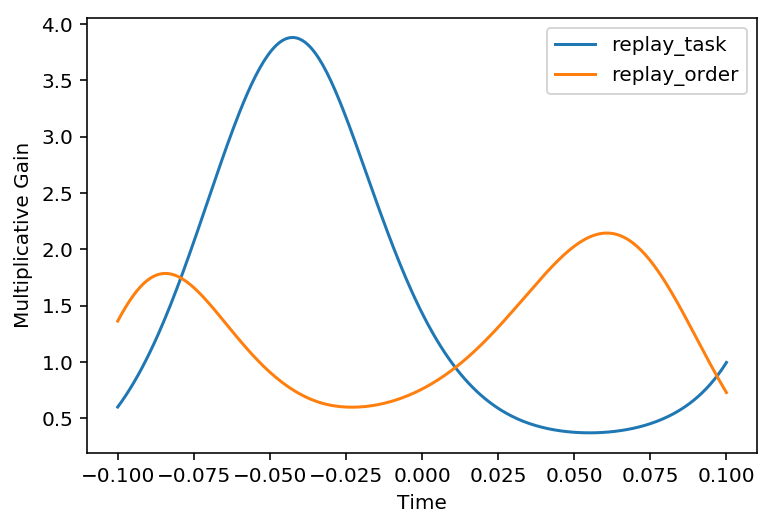

In [416]:
design_info = design_matrix.design_info
covariates = [term for term in design_info.term_names
              if 'time' not in term and
              'Intercept' not in term]
unique_time = data.time.unique()

for covariate in covariates:
    for not_baseline_level in np.unique(data[covariate])[1:]:
        predict_data = {'time': unique_time,
                        covariate: np.repeat(not_baseline_level, (n_time,))
                       }
        # doesn't capture bs(time, df=5) term
        # find spline interaction terms?
        subset = design_info.subset(
            [term for term in design_info.term_names
             if covariate in term])
        
        predict_design_matrix = build_design_matrices(
                [subset], predict_data)[0]
        is_covariate = np.array([covariate in column for column in design_info.column_names])
        predict_coefficients = fit.params[is_covariate]

        plt.plot(unique_time,
                 np.exp(np.dot(predict_design_matrix, predict_coefficients)),
                 label=covariate)
        plt.legend()
        
plt.xlabel('Time')
plt.ylabel('Multiplicative Gain')
        
np.exp(fit.params['Intercept']) * SAMPLING_FREQUENCY

### History, no replay covariates